Total games: 5000
White Sox wins: 964 (19.28%)
Cubs wins: 4036 (80.72%)
Ties: 0
Saved plot as run_dist_custom.png


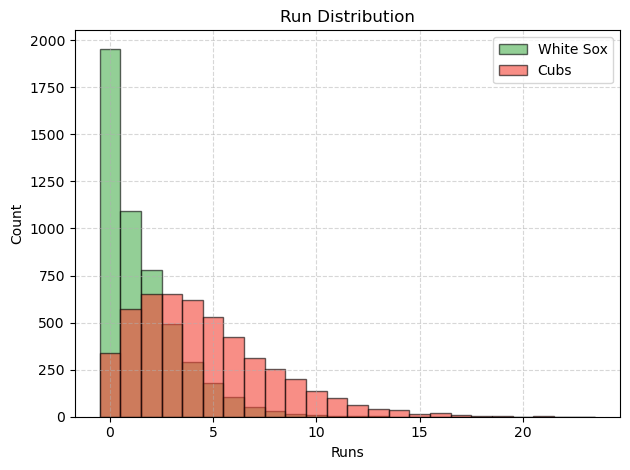

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

class Batter:
    def __init__(self, name, avg, obp, slg):
        self.name = name
        try:
            self.contact = float(avg)
            self.reach_base = float(obp)
            self.power = max((float(slg) - float(avg)) / 3, 0.05)
            self.k_rate = 0.18
            self.bb_rate = max(float(obp) - float(avg), 0.07)
        except:
            self.name = name + " (est.)"
            self.contact = 0.25
            self.reach_base = 0.32
            self.power = 0.10
            self.k_rate = 0.20
            self.bb_rate = 0.08

class Pitching:
    def __init__(self, name, era):
        self.name = name
        try:
            val = min(float(era), 5.0)
            self.cmd_factor = (5.0 - val) / 5.0
            self.k_boost = (5.0 - val) * 0.015
        except:
            self.name = name + " (est.)"
            self.cmd_factor = 0.88
            self.k_boost = 0.02

class MatchState:
    def __init__(self):
        self.inning = 1
        self.top_half = True
        self.out_count = 0
        self.bases = [0, 0, 0]
        self.score_home = 0
        self.score_away = 0
        self.home_idx = 0
        self.away_idx = 0

    def next_out(self):
        self.out_count += 1

    def reset_half(self):
        self.out_count = 0
        self.bases = [0, 0, 0]
        if self.top_half:
            self.top_half = False
        else:
            self.top_half = True
            self.inning += 1

    def move_runners(self, hit):
        runs = 0
        if hit == 4:
            runs = sum(self.bases) + 1
            self.bases = [0, 0, 0]
        elif hit == 0:
            if self.bases == [1, 1, 1]:
                runs += 1
            self.bases = [1] + self.bases[:2]
        else:
            for i in reversed(range(3)):
                if self.bases[i]:
                    target = i + hit
                    if target >= 3:
                        runs += 1
                    else:
                        self.bases[target] = 1
                    self.bases[i] = 0
            if hit >= 1 and hit <= 3:
                self.bases[hit - 1] = 1
        if self.top_half:
            self.score_away += runs
        else:
            self.score_home += runs


def play_at_bat(batter, pitcher, state):
    hit_prob = batter.contact * pitcher.cmd_factor
    bb_prob = batter.bb_rate / max(pitcher.cmd_factor, 0.1)
    k_prob = batter.k_rate + pitcher.k_boost

    total = hit_prob + bb_prob + k_prob
    miss_prob = max(0.01, 1.0 - total)
    norm = hit_prob + bb_prob + k_prob + miss_prob

    hit_prob /= norm
    bb_prob /= norm
    k_prob /= norm
    miss_prob /= norm

    outcome = random.random()
    if outcome < k_prob:
        state.next_out()
    elif outcome < k_prob + bb_prob:
        state.move_runners(0)
    elif outcome < k_prob + bb_prob + hit_prob:
        pwr = batter.power / max(batter.contact, 0.05)
        roll = random.random()
        if roll < pwr * 0.15:
            state.move_runners(4)
        elif roll < pwr * 0.4:
            state.move_runners(3)
        elif roll < pwr:
            state.move_runners(2)
        else:
            state.move_runners(1)
    else:
        state.next_out()


def play_half_inning(lineup, pitcher, state, batter_index):
    idx = batter_index
    while state.out_count < 3:
        play_at_bat(lineup[idx % len(lineup)], pitcher, state)
        idx += 1
    return idx % len(lineup)


def run_game(home_name, away_name, home_lineup, away_lineup, home_pitcher, away_pitcher, innings=9):
    game = MatchState()
    if not home_lineup or not away_lineup or not home_pitcher or not away_pitcher:
        return -1, -1

    while game.inning <= innings or game.score_home == game.score_away:
        if game.top_half:
            game.away_idx = play_half_inning(away_lineup, home_pitcher, game, game.away_idx)
        else:
            game.home_idx = play_half_inning(home_lineup, away_pitcher, game, game.home_idx)
        game.reset_half()

    return game.score_home, game.score_away


def load_batters(path, count=9):
    try:
        df = pd.read_csv(path)
        df = df[~df['Player'].str.contains("Team Totals", na=False)]
        if df.empty:
            return []
        while len(df) < count:
            df = pd.concat([df, df], ignore_index=True)
        return [Batter(row['Player'], row['BA'], row['OBP'], row['SLG']) for _, row in df.head(count).iterrows()]
    except:
        return []


def load_pitcher(path):
    try:
        df = pd.read_csv(path)
        df = df[~df['Player'].str.contains("Team Totals", na=False)]
        row = df.iloc[0]
        return Pitching(row['Player'], row['ERA'])
    except:
        return None

# Simulation Entry
if __name__ == "__main__":
    sims = 5000
    h_wins = 0
    a_wins = 0
    h_scores, a_scores = [], []

    cwd = os.getcwd()
    parent = os.path.dirname(cwd)
    datapath = os.path.join(parent, "prepared_data") + os.sep
    if not os.path.exists(datapath):
        datapath = os.path.join(cwd, "prepared_data") + os.sep

    cubs_bat = load_batters(datapath + "cubs_standard_batting_clean.csv")
    cubs_pit = load_pitcher(datapath + "cubs_standard_pitching_clean.csv")
    sox_bat = load_batters(datapath + "whitesox_standard_batting_clean.csv")
    sox_pit = load_pitcher(datapath + "whitesox_standard_pitching_clean.csv")

    for i in range(sims):
        hs, ascore = run_game("White Sox", "Cubs", sox_bat, cubs_bat, sox_pit, cubs_pit)
        if hs == -1:
            continue
        h_scores.append(hs)
        a_scores.append(ascore)
        if hs > ascore:
            h_wins += 1
        elif ascore > hs:
            a_wins += 1

    total_games = len(h_scores)
    print("Total games:", total_games)
    print("White Sox wins:", h_wins, f"({h_wins/total_games:.2%})")
    print("Cubs wins:", a_wins, f"({a_wins/total_games:.2%})")
    print("Ties:", total_games - h_wins - a_wins)

    bins = np.arange(0, max(h_scores + a_scores) + 2) - 0.5
    plt.hist(h_scores, bins=bins, alpha=0.6, label='White Sox', color='#4CAF50', edgecolor='black')
    plt.hist(a_scores, bins=bins, alpha=0.6, label='Cubs', color='#F44336', edgecolor='black')
    plt.title("Run Distribution")
    plt.xlabel("Runs")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("run_dist_custom.png")
    print("Saved plot as run_dist_custom.png")
